# Investigate issue #182

https://github.com/mjhoptics/ray-optics/issues/182#issue-3238200443

In [1]:
#%matplotlib inline
# use widget to enable interactive figures.
%matplotlib widget

In [2]:
isdark = False

In [3]:
from rayoptics.environment import *

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from rayoptics.gui import dashboards
from rayoptics.mpl.interactivelayout import InteractiveLayout

In [5]:
import numpy as np
from rayoptics.optical.opticalmodel import OpticalModel
from rayoptics.raytr.trace import trace_ray
from rayoptics.raytr.waveabr import transfer_to_exit_pupil
from rayoptics.elem import surface as srf
from rayoptics.elem.profiles import YToroid
from rayoptics.raytr.opticalspec import PupilSpec, FieldSpec, WvlSpec
from rayoptics.optical import model_constants as mc


def compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax):
    # trace one marginal ray at pupil coord [u,v]
    ray_pkg, trace_err = trace_ray(opm, [u, v], fld, wvl, apply_vignetting=False)

    if trace_err:
        raise RuntimeError(f"Ray trace failed: {trace_err}")

    ray_list, _, _ = ray_pkg
    pt_exit, dir_exit, _, _ = ray_list[-1]
    ray_seg = (pt_exit, dir_exit)
    exp_pt, exp_dir, *_ = transfer_to_exit_pupil(last_interface, ray_seg, exp_dst_parax)
    return np.hypot(exp_dir[0], exp_dir[1])


# ----------------------------
# Optical Model Setup
# ----------------------------
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

# Set model properties
opm.radius_mode = True
sm.do_apertures = False

# Optical specifications
epd = 3.0
osp['pupil'] = PupilSpec(osp, key=['object', 'epd'], value=epd)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=0.0, flds=[0.0])
osp['wvls'] = WvlSpec([(546.074, 1.0)], ref_wl=0)

# Surface 0: Object
sm.gaps[0].thi = 1e100

# Surface 1: STOP (Pupil)
sm.add_surface([0.0, 0.0, 'Air'], sd=1.5)
sm.set_stop()

# Surface 2: YToroid Anterior
gamma_rot = 0.
#gamma_rot = 30.
sm.add_surface([18., 2., 1.5], sd=5.0)
sm.ifcs[sm.cur_surface].profile = YToroid(r=18.0, rR=20.0, cc=0.0)
sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('dec and return')
sm.ifcs[sm.cur_surface].decenter.euler = np.array([0., 0., gamma_rot])  # rotate 30° Z

# Surface 3: Spherical Posterior
sm.add_surface([-20., 0., 'Air'], sd=5.0)

opm.update_model()

# Optimize Img position using paraxial ray tracing
ar = opm['analysis_results']
ax_ray = ar['parax_data'].ax_ray
prx_img_dist = -ax_ray[-1][mc.ht] / ax_ray[-1][mc.slp]
sm.gaps[-1].thi = prx_img_dist
exp_dst = pm.sys[-1][1]  # Distance from image to exit pupil
last_interface = sm.ifcs[-1]  # Image plane interface

opm.update_model()

sm.list_model()

# Ray-trace
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)
exp_dst_parax = ar['parax_data'].fod.exp_dist


# Entrance-pupil radius in mm
epd = osp['pupil'].value
rp = epd / 2.0

n = 361
phis = np.linspace(0, 2 * np.pi, n)  # 1° sampling

sin_thetas = np.empty(n)
for i, phi in enumerate(phis):
    u = rp * np.cos(phi)
    v = rp * np.sin(phi)
    sin_thetas[i] = compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax)

# find max & min
i_max = np.argmax(sin_thetas)
i_min = np.argmin(sin_thetas)

phi_max = phis[i_max] * 180 / np.pi
phi_min = phis[i_min] * 180 / np.pi

sin_max = sin_thetas[i_max]
sin_min = sin_thetas[i_min]

wfno_max = 1 / (2 * sin_max)
wfno_min = 1 / (2 * sin_min)

              r            t        medium     mode   zdr      sd
  Obj:     0.000000 1.00000e+100       air      dummy  1      1.0000
 Stop:     0.000000      0.00000       air             1      1.5000
    2:    18.000000      2.00000   n:1.500             1      5.0000
    3:   -20.000000      18.5714       air             1      5.0000
  Img:     0.000000      0.00000                dummy  1      1.0000


In [6]:
listobj(sm)

0: Obj: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=1.0
t=1e+100 (+1);    medium: air

1 (stop): transmit
profile: Spherical
c=0.0,   r=0.0
surface_od=1.5
t=0.0 (+1);    medium: air

2: transmit
profile: YToroid
sweep radius: rR=20.0
sweep profile: c=0.05555555555555555,   r=18.0   conic cnst=0.0
coefficients: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
decenter type: dec and return
decenter: [0. 0. 0.]
euler angles: [0. 0. 0.]
surface_od=5.0
t=2.0 (+1);    medium: n:1.500

3: transmit
profile: Spherical
c=-0.05,   r=-20.0
surface_od=5.0
t=18.57142857142857 (+1);    medium: air

4: Img: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=1.0

do apertures: False


In [7]:
set_vignetting(opm)

In [8]:
listobj(osp)

aperture: object epd; value=   3.00000
field: object angle; value=   0.00000
x,y=0.00 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000
is_relative=False, is_wide_angle=False
central wavelength=  546.0740 nm
wavelength (weight) =  546.0740 (1.000)*
focus shift=0.0



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


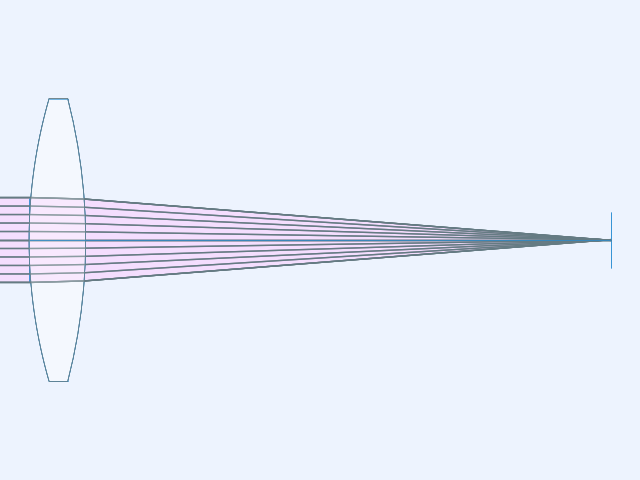

In [9]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_ray_fans=True, is_dark=False).plot()

In [10]:
print(f"{wfno_max=:6.3f}   {wfno_min=:6.3f}")

wfno_max= 4.230   wfno_min= 4.465


In [11]:
sm.list_model()

              r            t        medium     mode   zdr      sd
  Obj:     0.000000 1.00000e+100       air      dummy  1      1.0000
 Stop:     0.000000      0.00000       air             1      1.5000
    2:    18.000000      2.00000   n:1.500             1      5.0000
    3:   -20.000000      18.5714       air             1      5.0000
  Img:     0.000000      0.00000                dummy  1      1.0000


In [12]:
listobj(osp)

aperture: object epd; value=   3.00000
field: object angle; value=   0.00000
x,y=0.00 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000
is_relative=False, is_wide_angle=False
central wavelength=  546.0740 nm
wavelength (weight) =  546.0740 (1.000)*
focus shift=0.0



In [13]:
pm.first_order_data()

efl               19.29
f                 19.29
f'                19.29
ffl              -18.64
pp1              0.6429
bfl               18.57
ppk             -0.7143
pp sep           0.6429
f/#               6.429
m              1.11e-16
red          -5.185e+98
obj_dist         1e+100
obj_ang               1
enp_dist             -0
enp_radius          1.5
na obj         1.5e-100
n obj                 1
img_dist          18.57
img_ht           0.3366
exp_dist         -1.379
exp_radius        1.552
na img         -0.07778
n img                 1
optical invariant      0.02618


In [14]:
pm.list_model()

           ax_ht        pr_ht       ax_slp       pr_slp         power          tau        index    type
 0:            0 -1.74551e+98     1.5e-100    0.0174551             0       1e+100      1.00000    dummy
 1:          1.5            0     1.5e-100    0.0174551             0            0      1.00000    transmit
 2:          1.5            0   -0.0416667    0.0174551    0.02777778      1.33333      1.50000    transmit
 3:      1.44444    0.0232734   -0.0777778    0.0168732         0.025      18.5714      1.00000    transmit
 4:            0     0.336633   -0.0777778    0.0168732             0            0      1.00000    dummy


# Trace on-axis edge rays
```
r2 -> 0, +y
r3 -> 0, -y
r4 -> +x, 0
r5 -> -x, 0
```
List ray output in global coordinates wrt surface 1

In [15]:
f0 = osp['fov'].fields[0]
wvl = osp['wvls'].central_wvl

## no gamma rotation

In [16]:
list_ray(ray_f0_r2:=trace_ray(opm, [0, 1], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000     0.000000     1.000000       1e+100
  1:      0.00000      1.50000            0     0.000000     0.000000     1.000000     0.062609
  2:      0.00000      1.50000     0.062609     0.000000    -0.027842     0.999612       1.8857
  3:      0.00000      1.44750       1.9475     0.000000    -0.078226     0.996936       18.681
  4:      0.00000     -0.01386       20.571     0.000000    -0.078226     0.996936            0


In [17]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r2.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000   0.000000   1.000000
 1:   0.000000   0.000000   1.000000  |  0.000000   0.000000   1.000000
 2:   0.000000   0.000000   1.000000  |  0.000000  -0.027842   0.999612
 3:   0.000000  -0.027842   0.999612  |  0.000000  -0.078226   0.996936
 4:   0.000000  -0.078226   0.996936  |  0.000000  -0.078226   0.996936
 5:   0.000000  -0.078226   0.996936  |


In [18]:
list_ray(ray_f0_r3:=trace_ray(opm, [0, -1], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000    -0.000000     1.000000       1e+100
  1:      0.00000     -1.50000            0     0.000000    -0.000000     1.000000     0.062609
  2:      0.00000     -1.50000     0.062609     0.000000     0.027842     0.999612       1.8857
  3:      0.00000     -1.44750       1.9475     0.000000     0.078226     0.996936       18.681
  4:      0.00000      0.01386       20.571     0.000000     0.078226     0.996936            0


In [19]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r3.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000  -0.000000   1.000000
 1:   0.000000  -0.000000   1.000000  |  0.000000  -0.000000   1.000000
 2:   0.000000  -0.000000   1.000000  |  0.000000   0.027842   0.999612
 3:   0.000000   0.027842   0.999612  |  0.000000   0.078226   0.996936
 4:   0.000000   0.078226   0.996936  |  0.000000   0.078226   0.996936
 5:   0.000000   0.078226   0.996936  |


In [20]:
list_ray(ray_f0_r4:=trace_ray(opm, [1, 0], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000     0.000000     1.000000       1e+100
  1:      1.50000      0.00000            0     0.000000     0.000000     1.000000     0.056329
  2:      1.50000      0.00000     0.056329    -0.025047     0.000000     0.999686       1.8914
  3:      1.45263      0.00000       1.9472    -0.074149     0.000000     0.997247       18.676
  4:      0.06785      0.00000       20.571    -0.074149     0.000000     0.997247            0


In [21]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r4.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000   0.000000   1.000000
 1:   0.000000   0.000000   1.000000  |  0.000000   0.000000   1.000000
 2:   0.000000   0.000000   1.000000  | -0.025047   0.000000   0.999686
 3:  -0.025047   0.000000   0.999686  | -0.074149   0.000000   0.997247
 4:  -0.074149   0.000000   0.997247  | -0.074149   0.000000   0.997247
 5:  -0.074149   0.000000   0.997247  |


In [22]:
list_ray(ray_f0_r5:=trace_ray(opm, [-1, 0], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100    -0.000000     0.000000     1.000000       1e+100
  1:     -1.50000      0.00000            0    -0.000000     0.000000     1.000000     0.056329
  2:     -1.50000      0.00000     0.056329     0.025047     0.000000     0.999686       1.8914
  3:     -1.45263      0.00000       1.9472     0.074149     0.000000     0.997247       18.676
  4:     -0.06785      0.00000       20.571     0.074149     0.000000     0.997247            0


In [23]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r5.pkg.ray)

                  in_dir              |              out_dir
 0:                                   | -0.000000   0.000000   1.000000
 1:  -0.000000   0.000000   1.000000  | -0.000000   0.000000   1.000000
 2:  -0.000000   0.000000   1.000000  |  0.025047   0.000000   0.999686
 3:   0.025047   0.000000   0.999686  |  0.074149   0.000000   0.997247
 4:   0.074149   0.000000   0.997247  |  0.074149   0.000000   0.997247
 5:   0.074149   0.000000   0.997247  |


### calculate on-axis astigmatism

The calculation is done tracing close rays about the chief ray.

The unrotated case shows maximum astigmatism.

In [24]:
sag_r0, tan_r0 = trace_astigmatism(opm, f0, wvl, 0.)
print(f"{sag_r0=:6.3f}, {tan_r0=:6.3f}")

sag_r0= 1.090, tan_r0=-0.000


## 30 deg gamma rotation

In [25]:
gamma_rot = 30.
sm.ifcs[2].decenter.euler = np.array([0., 0., gamma_rot])
sm.ifcs[2].decenter.update()
opm.update_model()

In [26]:
list_ray(ray_f0_r2_g30:=trace_ray(opm, [0, 1], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000     0.000000     1.000000       1e+100
  1:      0.00000      1.50000            0     0.000000     0.000000     1.000000     0.061037
  2:     -0.00000      1.50000     0.061037     0.001208    -0.027142     0.999631       1.8871
  3:      0.00228      1.44878       1.9475     0.001755    -0.077204     0.997014        18.68
  4:      0.03506      0.00663       20.571     0.001755    -0.077204     0.997014            0


In [27]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r2_g30.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000   0.000000   1.000000
 1:   0.000000   0.000000   1.000000  |  0.000000   0.000000   1.000000
 2:   0.000000   0.000000   1.000000  | -0.012524  -0.024109   0.999631
 3:   0.001208  -0.027142   0.999631  |  0.001755  -0.077204   0.997014
 4:   0.001755  -0.077204   0.997014  |  0.001755  -0.077204   0.997014
 5:   0.001755  -0.077204   0.997014  |


In [28]:
list_ray(ray_f0_r3_g30:=trace_ray(opm, [0, -1], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000    -0.000000     1.000000       1e+100
  1:      0.00000     -1.50000            0     0.000000    -0.000000     1.000000     0.061037
  2:      0.00000     -1.50000     0.061037    -0.001208     0.027142     0.999631       1.8871
  3:     -0.00228     -1.44878       1.9475    -0.001755     0.077204     0.997014        18.68
  4:     -0.03506     -0.00663       20.571    -0.001755     0.077204     0.997014            0


In [29]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r3_g30.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000  -0.000000   1.000000
 1:   0.000000  -0.000000   1.000000  |  0.000000  -0.000000   1.000000
 2:  -0.000000  -0.000000   1.000000  |  0.012524   0.024109   0.999631
 3:  -0.001208   0.027142   0.999631  | -0.001755   0.077204   0.997014
 4:  -0.001755   0.077204   0.997014  | -0.001755   0.077204   0.997014
 5:  -0.001755   0.077204   0.997014  |


In [30]:
list_ray(ray_f0_r4_g30:=trace_ray(opm, [1, 0], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100     0.000000     0.000000     1.000000       1e+100
  1:      1.50000      0.00000            0     0.000000     0.000000     1.000000     0.057897
  2:      1.50000     -0.00000     0.057897    -0.025744     0.001206     0.999668         1.89
  3:      1.45134      0.00228       1.9473    -0.075165     0.001752     0.997170       18.677
  4:      0.04748      0.03500       20.571    -0.075165     0.001752     0.997170            0


In [31]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r4_g30.pkg.ray)

                  in_dir              |              out_dir
 0:                                   |  0.000000   0.000000   1.000000
 1:   0.000000   0.000000   1.000000  |  0.000000   0.000000   1.000000
 2:   0.000000  -0.000000   1.000000  | -0.021692   0.013917   0.999668
 3:  -0.025744   0.001206   0.999668  | -0.075165   0.001752   0.997170
 4:  -0.075165   0.001752   0.997170  | -0.075165   0.001752   0.997170
 5:  -0.075165   0.001752   0.997170  |


In [32]:
list_ray(ray_f0_r5_g30:=trace_ray(opm, [-1, 0], f0, wvl), tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000      -1e+100    -0.000000     0.000000     1.000000       1e+100
  1:     -1.50000      0.00000            0    -0.000000     0.000000     1.000000     0.057897
  2:     -1.50000      0.00000     0.057897     0.025744    -0.001206     0.999668         1.89
  3:     -1.45134     -0.00228       1.9473     0.075165    -0.001752     0.997170       18.677
  4:     -0.04748     -0.03500       20.571     0.075165    -0.001752     0.997170            0


In [33]:
rayoptics.raytr.trace.list_in_out_dir(sm.path(), ray_f0_r5_g30.pkg.ray)

                  in_dir              |              out_dir
 0:                                   | -0.000000   0.000000   1.000000
 1:  -0.000000   0.000000   1.000000  | -0.000000   0.000000   1.000000
 2:  -0.000000   0.000000   1.000000  |  0.021692  -0.013917   0.999668
 3:   0.025744  -0.001206   0.999668  |  0.075165  -0.001752   0.997170
 4:   0.075165  -0.001752   0.997170  |  0.075165  -0.001752   0.997170
 5:   0.075165  -0.001752   0.997170  |


### astigmatism for rotated case

The sagittal and tangential foci no longer sample the toroid's plane of symmetry.

In [34]:
sag_r30, tan_r30 = trace_astigmatism(opm, f0, wvl, 0.)
print(f"{sag_r30=:6.3f}, {tan_r30=:6.3f}")

sag_r30= 0.795, tan_r30= 0.251


## List the OPD for each fan at each field point

In [35]:
for i in range(len(osp['fov'].fields)):
    fld, wvl, foc = opm.optical_spec.lookup_fld_wvl_focus(i)
    tan_res = analyses.eval_fan(opm, fld, wvl, foc, 1, num_rays=11)
    sag_res = analyses.eval_fan(opm, fld, wvl, foc, 0, num_rays=11)

    print('FLD = {0}\n{1:>20} {2:>29}'.format(fld, 'tan', 'sag'))
    tan = [(val[0][0], val[0][1], val[1][2]) for val in tan_res]
    sag = [(val[0][0], val[0][1], val[1][2]) for val in sag_res]
    for pair in zip(tan, sag):
        print("{0:>6.3f} {1:>6.3f} {2:>10.7f}      {3:>6.3f} {4:>6.3f} {5:>10.7f}".format(*pair[0], *pair[1]))
    print("")

FLD = 0.0, 0.0
                 tan                           sag
 0.000 -1.000 -0.9504483      -1.000  0.000 -3.8218630
 0.000 -0.800 -0.7192765      -0.800  0.000 -2.5546207
 0.000 -0.600 -0.4529988      -0.600  0.000 -1.4843638
 0.000 -0.400 -0.2166636      -0.400  0.000 -0.6747295
 0.000 -0.200 -0.0564619      -0.200  0.000 -0.1709310
 0.000 -0.000 -0.0000000      -0.000  0.000 -0.0000000
 0.000  0.200 -0.0564619       0.200  0.000 -0.1709310
 0.000  0.400 -0.2166636       0.400  0.000 -0.6747295
 0.000  0.600 -0.4529988       0.600  0.000 -1.4843638
 0.000  0.800 -0.7192765       0.800  0.000 -2.5546207
 0.000  1.000 -0.9504483       1.000  0.000 -3.8218630



# Start of dynamic dashboard

## Set up the reference image point for the aberration calculations.

    Use the central ray from the on axis field point and take it's coordinates on the image interface as the definition for the on-axis image point

In [36]:
ctr_ray_result = trace_ray(opm, [0., 0.], fld, wvl)
ctr_ray = ctr_ray_result.pkg.ray

img_offset = ctr_ray[-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

In [37]:
ray_grid = analyses.RayGrid(opm, num_rays=48, f=fld, wl=wvl, image_pt_2d=on_axis_pt)
ray_list = analyses.RayList(opm, num_rays=48, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

## Set up useful measures

    To control the sensitivity of the control widgets below, calculate magnitudes of 1 wave perturbations.

In [38]:
opd_scale = 8.
img_scale = 0.1

focus_range = 2.0
shift_range = 0.2

## 2D Histogram and Spot Diagram

    This plot shows both a spot diagram and a 2D histogram display, using the same RayList instance as used above.

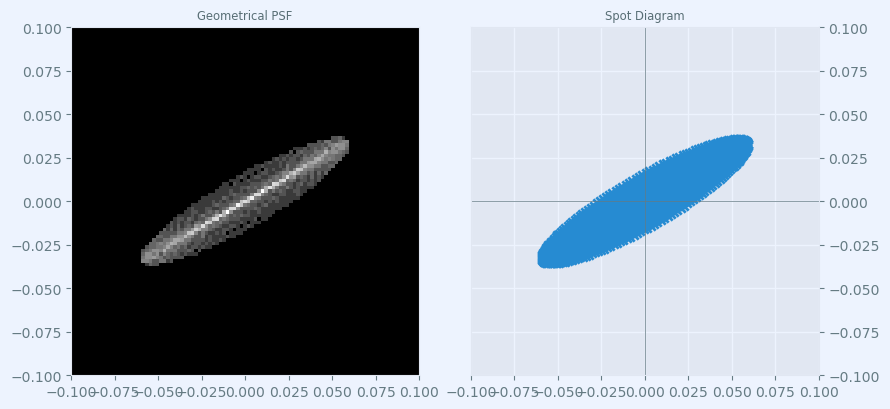

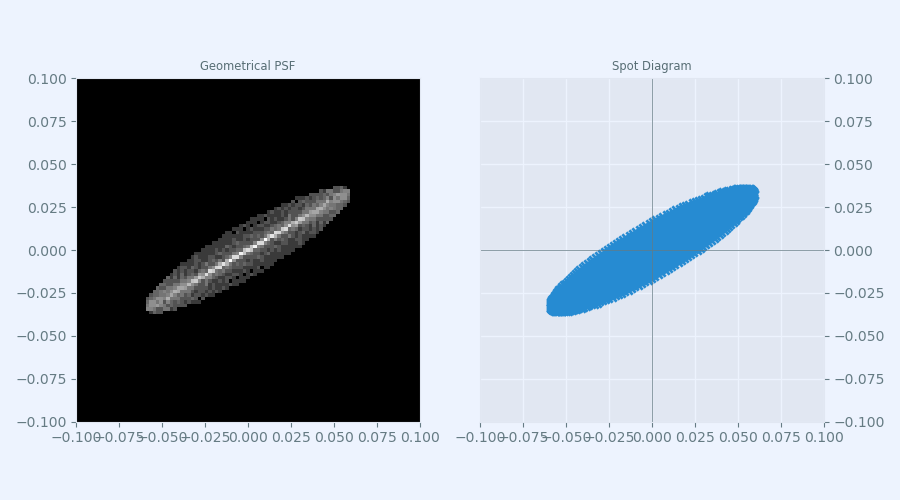

In [39]:
#scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=img_scale, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='left', title='Geometrical PSF', cmap='gray')
gSPO = RayGeoPSF(ray_list, user_scale_value=img_scale, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')

spotfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list], subplots=[gPSF, gSPO],
                     grid=(1, 2), figsize=[9, 5], tight_layout=True, is_dark=isdark)
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=spotfig)

image_defocus = ray_list.foc
image_delta = ray_list.image_delta
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([spotfig],
                                                              [ray_grid, ray_list],
                                                              image_defocus, focus_range, shift_range, image_delta)

spotfig.plot()

In [40]:
display(widgets.HBox([defocus, y_shift]))

## Wavefront and Ray Aberration Display

In [41]:
grid_width=48
wfr_grid = analyses.RayGrid(opm, num_rays=grid_width, f=fld, wl=wvl)

r2g = (sampler.create_generator, (sampler.R_2_quasi_random_generator, grid_width**2),
       dict(mapper=sampler.concentric_sample_disk))
tabr_list = analyses.RayList(opm, pupil_gen=r2g, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

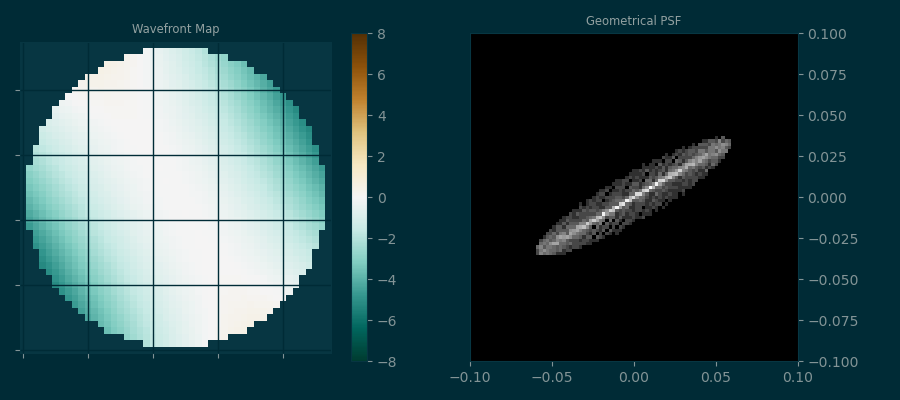

In [42]:
wfr = Wavefront(wfr_grid, user_scale_value=opd_scale, do_contours=False,
                title='Wavefront Map', cmap="BrBG_r")

scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(tabr_list, user_scale_value=img_scale, scale_type='user', dsp_typ='hist2d', gamma=1./1.8,
                 title='Geometrical PSF', yaxis_ticks_position='right', #norm=scaler, vmax=80,
                 cmap='gray')

wvfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[wfr_grid, tabr_list], subplots=[wfr, gPSF],
                   grid=(1, 2), figsize=[9, 4], tight_layout=True, is_dark=True)

image_defocus = wfr_grid.foc
image_delta = wfr_grid.image_delta
defocus_wfr, x_shift_wfr, y_shift_wfr = dashboards.create_focus_dashboard([wvfig], [wfr_grid, tabr_list],
                                                              image_defocus, focus_range, 
                                                              shift_range, image_delta)
wvfig_out = wvfig.plot()

In [43]:
display(widgets.HBox([defocus_wfr, y_shift_wfr]))